In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
torch.use_deterministic_algorithms(True)

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5)
        # fully connected layers of size 120, 84 and 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Flatten spatial and depth dimensions into a single vector
        x = x.view(-1, self.flattened_features(x))
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats
    
lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
def train(net, trainloader, optim, epoch):
    loss_total = 0.0
    for i, data in enumerate(trainloader):
        ip, ground_truth = data
        optim.zero_grad()

        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()
        loss_total += loss

        if (i+1) % 1000 == 0:
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0



In [2]:
def test(net, testloader):
    success = 0
    counter = 0

    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()
    print('LeNet accuracy on 10000 images from test dataset: %d %%'\
        % (100 * success / counter))



In [5]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, 4),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),
                          (0.5,0.5,0.5))
    ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10000, shuffle=False )

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:18<00:00, 9254303.26it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


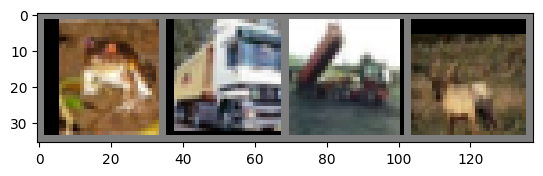

    frog  ||  truck  ||  truck  ||  deer


In [6]:
# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

In [13]:
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

for epoch in range(50):
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')


LeNet accuracy on 10000 images from test dataset: 15 %


LeNet accuracy on 10000 images from test dataset: 15 %


LeNet accuracy on 10000 images from test dataset: 22 %


LeNet accuracy on 10000 images from test dataset: 25 %


LeNet accuracy on 10000 images from test dataset: 28 %


LeNet accuracy on 10000 images from test dataset: 29 %


LeNet accuracy on 10000 images from test dataset: 30 %


LeNet accuracy on 10000 images from test dataset: 31 %


LeNet accuracy on 10000 images from test dataset: 32 %


LeNet accuracy on 10000 images from test dataset: 33 %


LeNet accuracy on 10000 images from test dataset: 34 %


LeNet accuracy on 10000 images from test dataset: 36 %


LeNet accuracy on 10000 images from test dataset: 37 %


LeNet accuracy on 10000 images from test dataset: 38 %


LeNet accuracy on 10000 images from test dataset: 39 %


LeNet accuracy on 10000 images from test dataset: 40 %


LeNet accuracy on 10000 images from test dataset: 40 %


LeNet accuracy on 10000 images

In [15]:
model_path = 'cifar_model.pth'
torch.save(lenet.state_dict(),model_path)

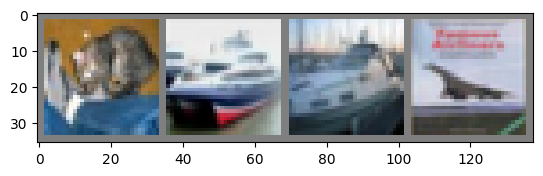

Label:         cat  ship  ship plane
Prediction:    cat  ship  ship  ship


In [18]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# model inference
op = lenet_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [19]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 49 %
